# 1000 Genomes project

Project dashboard:
    * Switch vcf file read from pandas to numpy or scipy.sparse to deal with large amounts of data
    * Create interactive 3D plot
    * Extract full variants file on server
    

In [1]:
import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Dataset creation

In [5]:
variants_path = 'test.vcf'#'test_100000.vcf'#'test'
phenotypes_path = '20130606_g1k.ped'
populations_path = '20131219.populations.tsv'

### Genotype data

In [6]:
# SOURCE: https://gist.github.com/dceoy/99d976a2c01e7f0ba1c813778f9db744
def read_vcf(path):
    """
    Read a .vcf file as pandas DataFrame
    Input:
        path: str. File to read
    Returns:
        data: pd.DataFrame
    """
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [7]:
variants = read_vcf(variants_path)

In [8]:
variants.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,20,60343,rs527639301,G,A,100,PASS,AC=1;AF=0.000199681;AN=5008;NS=2504;DP=20377;E...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,20,60419,rs538242240,A,G,100,PASS,AC=1;AF=0.000199681;AN=5008;NS=2504;DP=19865;E...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
2,20,60479,rs149529999,C,T,100,PASS,AC=17;AF=0.00339457;AN=5008;NS=2504;DP=20218;E...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
3,20,60522,rs150241001,T,TC,100,PASS,AC=68;AF=0.0135783;AN=5008;NS=2504;DP=20754;EA...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,20,60568,rs533509214,A,C,100,PASS,AC=1;AF=0.000199681;AN=5008;NS=2504;DP=20728;E...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


Documentation about vcf file format: http://www.internationalgenome.org/wiki/Analysis/Variant%20Call%20Format/vcf-variant-call-format-version-40/

In [9]:
variants.iloc[0, 7]

'AC=1;AF=0.000199681;AN=5008;NS=2504;DP=20377;EAS_AF=0;AMR_AF=0.0014;AFR_AF=0;EUR_AF=0;SAS_AF=0;AA=.|||;VT=SNP'

In [10]:
variants['HG00096'].value_counts()

0|0    716
1|1     12
1|0     11
0|1      7
2|0      1
Name: HG00096, dtype: int64

In [35]:
variants.set_index('POS', inplace=True)
variants.head()

,CHROM,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,HG00097,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
POS,,,,,,,,,,,,,,,,,,,,,
60343,20,rs527639301,G,A,100,PASS,AC=1;AF=0.000199681;AN=5008;NS=2504;DP=20377;E...,GT,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
60419,20,rs538242240,A,G,100,PASS,AC=1;AF=0.000199681;AN=5008;NS=2504;DP=19865;E...,GT,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
60479,20,rs149529999,C,T,100,PASS,AC=17;AF=0.00339457;AN=5008;NS=2504;DP=20218;E...,GT,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
60522,20,rs150241001,T,TC,100,PASS,AC=68;AF=0.0135783;AN=5008;NS=2504;DP=20754;EA...,GT,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
60568,20,rs533509214,A,C,100,PASS,AC=1;AF=0.000199681;AN=5008;NS=2504;DP=20728;E...,GT,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [36]:
matrix = variants.drop(columns=['CHROM', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT']).transpose()
matrix = pd.get_dummies(matrix, drop_first=True)
matrix.head()

,60343_0|1,60419_0|1,60479_0|1,60479_1|0,60522_0|1,60522_1|0,60522_1|1,60568_1|0,60571_0|1,60571_1|0,...,3336192_1|0,3336192_1|1,3336218_0|1,3336218_1|0,3336218_1|1,3336273_0|1,3336273_1|0,3336273_1|1,3336300_0|1,3336300_1|0
HG00096,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
HG00097,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
HG00099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
HG00100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00101,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Phenotype data > TO BE COMPLETED

In [10]:
def read_file(path):
    """
    A simple parser for reading tsv and ped files from the 1000 genomes project 
    Input:
        path: path to file
    Returns:
        data: pd.DataFrame
    """
    with open(path, 'r') as f:
        lines = [l for l in f]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        sep='\t'
    )

In [11]:
phenotypes = read_file(phenotypes_path)
phenotypes.head()

,Family ID,Individual ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Other Comments
0,BB01,HG01879,0,0,1,0,ACB,father,0,0,0,0
1,BB01,HG01880,0,0,2,0,ACB,mother,0,0,0,0
2,BB01,HG01881,HG01879,HG01880,2,0,ACB,child,0,0,0,0
3,BB02,HG01882,0,0,1,0,ACB,father,0,0,0,0
4,BB02,HG01883,0,0,2,0,ACB,mother,0,0,0,0


In [14]:
populations = read_file(populations_path)
populations.head()

,Population Description,Population Code,Super Population,DNA from Blood,Offspring available from trios,Pilot Samples,Phase1 Samples,Final Phase Samples,Total
0,"Chinese Dai in Xishuangbanna, China",CDX,EAS,no,yes,0.0,0.0,99.0,99.0
1,"Han Chinese in Bejing, China",CHB,EAS,no,no,91.0,97.0,103.0,106.0
2,"Japanese in Tokyo, Japan",JPT,EAS,no,no,94.0,89.0,104.0,105.0
3,"Kinh in Ho Chi Minh City, Vietnam",KHV,EAS,yes,yes,0.0,0.0,101.0,101.0
4,"Southern Han Chinese, China",CHS,EAS,no,yes,0.0,100.0,108.0,112.0


In [20]:
# TODO: MERGE TO BE IMPROVED TO AVOID REDUNDANCY
phenotypes = phenotypes.merge(right=populations[['Population Code', 'Super Population']],
                              how='left', left_on='Population', right_on='Population Code')
phenotypes.head()

,Family ID,Individual ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Other Comments,Population Code,Super Population
0,BB01,HG01879,0,0,1,0,ACB,father,0,0,0,0,ACB,AFR
1,BB01,HG01880,0,0,2,0,ACB,mother,0,0,0,0,ACB,AFR
2,BB01,HG01881,HG01879,HG01880,2,0,ACB,child,0,0,0,0,ACB,AFR
3,BB02,HG01882,0,0,1,0,ACB,father,0,0,0,0,ACB,AFR
4,BB02,HG01883,0,0,2,0,ACB,mother,0,0,0,0,ACB,AFR


## Principal Component Analysis

In [ ]:
# Applying PCA without feature scaling
from sklearn.decomposition import PCA
pca = PCA(n_components = None, random_state = 0)
pca_result = pca.fit_transform(matrix)
explained_variance = pca.explained_variance_ratio_

In [23]:
n_components = 3
for i in range(n_components):
    print(f'Explained variation by principal component {i+1}: {pca.explained_variance_ratio_[i]:.4f}')
    
print(f'\nExplained variation by first {n_components} principal components: {sum(pca.explained_variance_ratio_[:n_components]):.4f}')

Explained variation by principal component 1: 0.1047
Explained variation by principal component 2: 0.0868
Explained variation by principal component 3: 0.0589

Explained variation by first 3 principal components: 0.2505


In [24]:
pca_result.shape

(2504, 1175)

In [25]:
pca_df = pd.DataFrame(pca_result[:,:3], columns=['PCA_1', 'PCA_2', 'PCA_3'])
pca_df = pca_df.set_index(matrix.index)

In [26]:
pca_df.head()

,PCA_1,PCA_2,PCA_3
HG00096,-1.647569,-1.052419,0.019985
HG00097,0.133984,0.026624,0.098733
HG00099,-0.503153,-0.976154,0.089703
HG00100,-1.871238,0.287211,-0.579028
HG00101,1.485011,0.725929,-1.218336


In [27]:
pca_df = pca_df.merge(right=phenotypes, how='left', left_index=True, right_on='Individual ID')
pca_df.head()

,PCA_1,PCA_2,PCA_3,Family ID,Individual ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Other Comments,Population Code,Super Population
1385,-1.647569,-1.052419,0.019985,HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,GBR,EUR
1386,0.133984,0.026624,0.098733,HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,GBR,EUR
1388,-0.503153,-0.976154,0.089703,HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,GBR,EUR
1389,-1.871238,0.287211,-0.579028,HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,GBR,EUR
1390,1.485011,0.725929,-1.218336,HG00101,HG00101,0,0,1,0,GBR,unrel,0,0,0,0,GBR,EUR


### 2D scatter plot

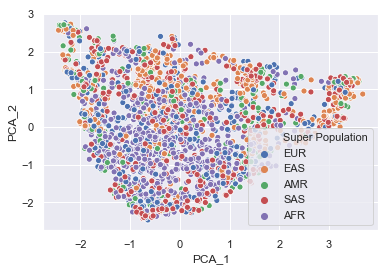

In [28]:
sns.scatterplot(x='PCA_1', y='PCA_2', data=pca_df, hue='Super Population');

### TODO: 3D scatter plot